# Initial mortality and recovery in reported cases of COVID-19 a few weeks into the pandemic

## Carlos Ignacio Herrera-Nolasco$^1$, Alejandro Joel Herrera-McKiernan$^2$, 
## Emilio Arieli Herrera-McKiernan$^3$, Eugenia O'Reilly-Regueiro$^4$,
## Marco Arieli Herrera-Valdez$^1$

#### $^1$ Departamento de Matemáticas, Facultad de Ciencias, Universidad Nacional Autónoma de México
#### $^2$ Escuela Primaria República de Guatemala, Secretaría de Educación Pública, México
#### $^3$ Escuela Secundaria Vicente Guerrero, Secretaría de Educación Pública, México
#### $^4$ Instituto de Matemáticas, Facultad de Ciencias, Universidad Nacional Autónoma de México

Last modified: MAHV, 20200411

### Abstract


### Methods and data sources

The data was downloaded from the repository for the 2019 Novel Coronavirus Visual Dashboard operated by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE) (https://github.com/CSSEGISandData/COVID-19). All calculations were performed using Python version 3.82 (https://www.python.org/) and the modules numpy (https://numpy.org/), matplotlib (https://matplotlib.org/), and pandas (https://pandas.pydata.org/). A JuPyTeR notebook with the analysis and calculations performed here can be found at 



Module imports (all basic functions and other module specs can be found in [tsam_COVID19_baseCode.py](tsam_COVID19_baseCode.py)

In [5]:
import sys
sys.path.insert(1, '../')
from tsam_Covid19_baseCode import *
%matplotlib inline 

Data for Mexico obtained from http://187.191.75.115/gobmx/salud/datos_abiertos/datos_abiertos_covid19.zip
Data obtained from https://github.com/CSSEGISandData/COVID-19/


In [6]:
cases, deathCases,recovCases = getCSSEGISandData(urlData=1)

Let us first describe the data set. The data has been transposed so that the cases, deaths, and recovered the different regions of the world are stored in columns, each with the data from different dates starting from January 22, 2020. 

In [7]:
cases.head(6)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,521,555,607,665,714,784,840,906,933,996
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,416,433,446,467,475,494,518,539,548,562
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,601,601,638,646,659,673,673,696,704,713
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,19,19,19,19,19,19,19,19,24,24
5,NaN,Antigua and Barbuda,17.0608,-61.7964,0,0,0,0,0,0,...,19,21,21,23,23,23,23,23,23,23


In [8]:
deathCases.tail(4)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20
260,NaN,South Sudan,6.877000,31.307000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
261,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
262,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
263,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


This means there are 4 columns before the time series begins, and the data contains 248 regions from the world. The data that can be used for calculations involving the cases in the epidemic can be found from the fifth row on.  Since the dates in the original data have only two numbers for the year, let us create a date range with the dates formatted with a four figures, and use the new dates later for the plots and illustrations.

In [9]:
# ------------------------------
# Description of the data so that the headers and the columns
# without case data are distinguished
# ------------------------------
nRows,nCols=cases.shape
cases.head(10)
nHeaderRows=1;
#
nHeaderCols=3
# how to generate date lists from a baseline using the datetime
dates = cases.columns[4:]
nDays = len(dates)
print('Got data from %d days between %s and %s'%(nDays,dates[0],dates[-1]))


Got data from 89 days between 1/22/20 and 4/19/20


In [10]:
# -------------------
print("""""")
# -------------------
npCases = cases.to_numpy()
countries = np.unique(npCases[:,1])
nCountries = len(countries)
print('Considering data from {d} countries'.format(d=nCountries))


Considering data from 185 countries


Data curation observations.
- Some countries report by province. This allows examination of the time series with a better spatial resolution.
The countries where there are reports by province are China, United Kingdom, Australia, and Canada.
- Arrays that include whole country cases, deaths, and recovered obtained
and separated for analysis
- Recovered are treated separately because reports do not include as many places as cases or deaths
- Case fatality ratios are calculated to analyse the epidemia in different provinces and contrast with whole country estimates


In [11]:
# -------------------
# Gather same country data
# -------------------
gCases, countries_Cases= sortDataByCountry(cases, nHeaderCols)
gDeaths,countries_DeathCases = sortDataByCountry(deathCases, nHeaderCols)
gRecovCases,countries_RecovCases = sortDataByCountry(recovCases, nHeaderCols)

# -------------------
# Sum the counts from each country and construct a new array
# -------------------
# These arrays have the same size as the countries array (unique countries)
totCases=gatherDataByCountry(df=cases,nHeaderCols=4)
totDeathCases=gatherDataByCountry(df=deathCases,nHeaderCols=4)
totRecovCases=gatherDataByCountry(df=recovCases,nHeaderCols=4)


## Delays relative to the first case report in different countries

To get an idea of the initial the dynamics of the pandemic, we calculated the delays to the first case reports and compare to the first deaths reported by country. 

In [12]:
# Describe the order of appearance of cases
dFC=findFirstCaseDates(totCases)
dFD=findFirstCaseDates(totDeathCases)
dFR=findFirstCaseDates(totRecovCases)
iArrival = dFC.argsort()
for n in range(37):
    print(countries[n],dFC[n],dFD[n],dFR[n],'rank: %dth'%iArrival[n])
 
d0SortedCountries = countries[iArrival]
sdFC = dFC[iArrival]
sdFD = dFD[iArrival]
sdFR = dFR[iArrival]

('Afghanistan', 33, 60, 54, 'rank: 36th')
('Albania', 47, 49, 59, 'rank: 171th')
('Algeria', 34, 50, 50, 'rank: 165th')
('Andorra', 40, 60, 50, 'rank: 163th')
('Angola', 58, 67, 69, 'rank: 86th')
('Antigua and Barbuda', 51, 76, 83, 'rank: 90th')
('Argentina', 41, 46, 52, 'rank: 179th')
('Armenia', 39, 64, 55, 'rank: 150th')
('Australia', 4, 39, 8, 'rank: 61th')
('Austria', 34, 50, 47, 'rank: 119th')
('Azerbaijan', 39, 51, 49, 'rank: 105th')
('Bahamas', 54, 70, 62, 'rank: 32th')
('Bahrain', 33, 54, 44, 'rank: 8th')
('Bangladesh', 46, 56, 54, 'rank: 65th')
('Barbados', 55, 74, 74, 'rank: 30th')
('Belarus', 37, 69, 47, 'rank: 157th')
('Belgium', 13, 49, 26, 'rank: 60th')
('Belize', 61, 75, 88, 'rank: 174th')
('Benin', 54, 75, 69, 'rank: 78th')
('Bhutan', 44, 88, 71, 'rank: 133th')
('Bolivia', 49, 67, 70, 'rank: 160th')
('Bosnia and Herzegovina', 43, 59, 55, 'rank: 84th')
('Botswana', 68, 69, 88, 'rank: 175th')
('Brazil', 35, 55, 54, 'rank: 138th')
('Brunei', 47, 66, 58, 'rank: 156th')
('B

In [13]:
# As many as countries
print('%First case, & to first death & to first recovery \\\\')
print('\hline &&&\\\\')
for mm in range(nCountries):
    #print('%s & %s & %s & %s\\\\'%(countries[jj[mm]], dates[siC[mm]], dates[siD[mm]], dates[siR[mm]]))
    #print('& %d & %d & %d \\\\ '%(siC[mm],siD[mm]-siC[mm],siR[mm]-siC[mm]))
    sss = [d0SortedCountries[mm], dates[sdFC[mm]], sdFC[mm], dates[sdFD[mm]], sdFD[mm]-sdFC[mm], dates[sdFR[mm]], sdFR[mm]-sdFC[mm]]
    print('{s[0]} & {s[1]} ({s[2]})  & {s[3]} ({s[4]})  & {s[5]} ({s[6]}) \\\\'.format(s=sss))
    if (mm<nCountries-1):
        if (sdFC[mm]<sdFC[mm+1]):
            print('\hline ')

%First case, & to first death & to first recovery \\
\hline &&&\\
China & 1/22/20 (0)  & 1/22/20 (0)  & 1/22/20 (0) \\
US & 1/22/20 (0)  & 2/29/20 (38)  & 2/9/20 (18) \\
Thailand & 1/22/20 (0)  & 3/1/20 (39)  & 1/26/20 (4) \\
Taiwan* & 1/22/20 (0)  & 2/16/20 (25)  & 2/6/20 (15) \\
Japan & 1/22/20 (0)  & 2/13/20 (22)  & 1/26/20 (4) \\
Korea, South & 1/22/20 (0)  & 2/20/20 (29)  & 2/7/20 (16) \\
\hline 
Vietnam & 1/23/20 (1)  & 4/19/20 (87)  & 2/1/20 (9) \\
Singapore & 1/23/20 (1)  & 3/21/20 (58)  & 2/8/20 (16) \\
\hline 
France & 1/24/20 (2)  & 2/15/20 (22)  & 2/12/20 (19) \\
\hline 
Nepal & 1/25/20 (3)  & 4/19/20 (85)  & 2/12/20 (18) \\
Malaysia & 1/25/20 (3)  & 3/17/20 (52)  & 2/7/20 (13) \\
\hline 
Canada & 1/26/20 (4)  & 3/9/20 (43)  & 2/12/20 (17) \\
Australia & 1/26/20 (4)  & 3/1/20 (35)  & 1/30/20 (4) \\
\hline 
Germany & 1/27/20 (5)  & 3/9/20 (42)  & 2/13/20 (17) \\
Cambodia & 1/27/20 (5)  & 4/19/20 (83)  & 2/12/20 (16) \\
Sri Lanka & 1/27/20 (5)  & 3/28/20 (61)  & 2/8/20 (12) \

## The time course of reports

In [14]:
nCountriesFCByDate= list()
nCountriesFDByDate= list()
nCountriesFRByDate= list()
for m in range(nDays):
    # Find the indices of those who reported their first case on day m
    nCountriesFCByDate.append(len(np.where(dFC==m)[0])) 
    # Find the indices of those who reported their first death on day m
    nCountriesFDByDate.append(len(np.where(dFD==m)[0])) 
    nCountriesFRByDate.append(len(np.where(dFR==m)[0])) 
nCountriesFCByDate = np.array(nCountriesFCByDate)
nCountriesFDByDate = np.array(nCountriesFDByDate)
nCountriesFRByDate = np.array(nCountriesFRByDate)
cumC=nCountriesFCByDate.cumsum()
cumD=nCountriesFDByDate.cumsum()
cumR=nCountriesFRByDate.cumsum()

In [15]:
print(nCountriesFCByDate,len(nCountriesFCByDate))
print(nCountriesFDByDate,len(nCountriesFDByDate))
print(nCountriesFRByDate,len(nCountriesFRByDate))

(array([ 6,  2,  1,  2,  2,  3,  0,  2,  2,  4,  1,  0,  0,  1,  0,  0,  1,
        0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  1,  0,  2,  0,  0,  5,
        4,  7,  4,  6,  4,  5,  7,  4,  4,  4,  9,  1,  5,  3,  3,  6,  2,
        6, 14,  4,  5,  3,  4,  4,  7,  2,  5,  1,  2,  3,  1,  1,  1,  0,
        1,  2,  0,  1,  0,  0,  2,  1,  0,  0,  0,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0]), 89)
(array([ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  0,  1,  1,  0,  0,  1,  2,  1,  0,  0,  0,
        0,  0,  0,  0,  1,  2,  0,  2,  1,  2,  1,  0,  2,  2,  2,  9,  4,
        3,  5,  2,  2,  5,  5,  7,  5,  9,  8,  4,  2,  4,  5,  6,  3,  8,
        1,  6,  3,  3,  3,  4,  3,  2,  2,  2,  0,  1,  0,  0,  1,  0,  1,
        1,  0,  0, 32]), 89)
(array([ 1,  0,  0,  0,  2,  0,  0,  0,  1,  0,  1,  0,  0,  0,  0,  1,  2,
        2,  1,  0,  0,  9,  1,  0,  1,  1,  1,  0,  1,  0,  0,  1,  0,  0,
        0,  1,  1,  1,  1,  0,  0,  2, 

The first countries that reported cases of COVID-19 on January 22, 2020 ($d_0$) were South Korea, China, Taiwan, US, Japan, and Thailand. Australia reported their first case 4 days later, together with Canada, on January 26, 2020. The first reports from Europe came 5 days later from Germany, on January 27. The first report in the Middle East came from the United Arab Emirates on January 29, 7 days after the first case reported. 
Therefore, the COVID-19 epidemic had been reported from all continents but Africa one week after the first case was reported, and the first report from Africa arrived 23 days later from Egypt, on February 14, 2020.
These data indicate that the COVID-19 epidemic was wide spread throughout the globe within 2 weeks of the first case, strongly suggesting that the dissemination of the SARS-CoV-2 virus among the human population occurred with a delay of approximately 2 weeks. 

These data reflect the delay in reports from different countries relative to $d_0$. Of note, 25 countries reported cases within 10 days from $d_0$, and 31 countries had reports within the first 30 days. 
Of interest to the authors, Mexico reported their first case 37 days later, on February 28, 2020, together with Nigeria, New Zealand, Lithuania, Iceland, and Belarous. The last country that reported cases was Sao Tome and Principe, on April 6th, 2020, 75 days after the first report.


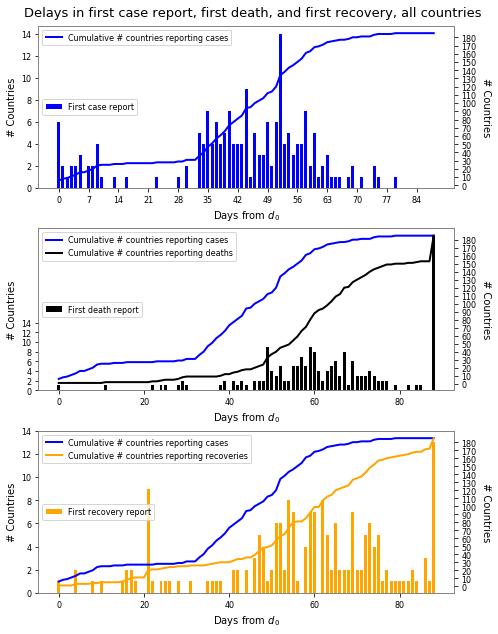

In [79]:
#cFirstCases, binsC = np.histogram(dFC,np.arange(0,(iFD-iFC).max()))
days = np.arange(nDays)

def plotCaseArrivals():
    shift=0.3; W=.7
    fRepArrivals= gr.figure(figsize=(7,9)); 
    gr.ioff(); rows=3; cols=1;
    ticks = np.arange(0,nDays,7)
    ax=list(); tAx=list()
    for m in range(cols*rows):
        ax.append(fRepArrivals.add_subplot(rows,cols,m+1))
        tAx.append(ax[m].twinx())
    tAx[0].plot(cumC,'b',lw=2, label='Cumulative # countries reporting cases')
    tAx[1].plot(cumC,'b',lw=2, label='Cumulative # countries reporting cases')
    tAx[1].plot(cumD,'k',lw=2,label='Cumulative # countries reporting deaths')
    tAx[2].plot(cumC,'b',lw=2, label='Cumulative # countries reporting cases')
    tAx[2].plot(cumR,'orange',lw=2, label='Cumulative # countries reporting recoveries')
    ax[0].bar(days,nCountriesFCByDate,color='blue',align='center',width=W,label='First case report')
    ax[1].bar(days,nCountriesFDByDate,color='black',align='center',width=W,label='First death report')
    ax[2].bar(days,nCountriesFRByDate,color='orange',align='center',width=W,label='First recovery report')
    ax[0].set_xticks(ticks)
    for m in range(cols*rows):
        tAx[m].set_yticks(np.arange(0,nCountries+1,10))
        ax[m].set_yticks(np.arange(0,nCountriesFCByDate.max()+1,2))
        ax[m].set_ylabel('# Countries',rotation=90)
        tAx[m].set_ylabel('# Countries',rotation=-90,labelpad=15)
        ax[m].legend(loc='center left')
        tAx[m].legend(loc='upper left')
    #    for label in ax[m].get_xticklabels():
    #        label.set_rotation(45)
    #        label.set_horizontalalignment('center')
    #        label.set_fontsize(8)
    #        label.set_horizontaloffset=-15
    for mm in range(rows*cols):
        ax[mm].set_xlabel('Days from $d_0$')
    fRepArrivals.subplots_adjust(left=0.075,bottom=0.075,right=0.9,top=0.95,wspace=0.1,hspace=0.25)
    fRepArrivals.suptitle('Delays in first case report, first death, and first recovery, all countries')
    gr.ion(); gr.draw(); gr.show()
    fRepArrivals.savefig('./figures/tsam_Covid19_JHU_reportArrivals_AllCountries.png')
    return fRepArrivals

fRepArrivals= plotCaseArrivals()

In [80]:
n=7; print(r'%d countries reported within the first %d days from $d_0$'%(len(sdFC[sdFC<n+1]),n))
countries[iArrival[(sdFD-sdFC) <n+1]]

18 countries reported within the first 7 days from $d_0$


array(['China', 'Philippines', 'Iran', 'San Marino', 'Argentina',
       'Bulgaria', 'Albania', 'Panama', 'Turkey', 'Cuba', 'Guyana',
       'Sudan', 'Kazakhstan', 'Gabon', 'Ghana', 'Guatemala', 'Montenegro',
       'Gambia', 'Mauritius', 'Niger', 'Cabo Verde', 'Zimbabwe', 'Syria',
       'Mali', 'Kosovo', 'Burma', 'MS Zaandam', 'Botswana', 'Malawi'],
      dtype=object)

The difference between the curve of cumulative number of countries reporting cases and the cumulative number of countries reporting deaths is very similar for a large interval of days. 
The descriptive statistics of delay between death and case reports are as follows. 

The delays between the first case reported and the first death reported within a single country have a wide distribution, between 0 and 76 days. 
However, the bulk of the distribution can be found between 0 and 30 days, with a mode at 16 days. In consideration of the time course of the infection by SARS-CoV-2 reported in the literature \citep{}, the delay between death and contagion can be 21 or more days \citep{}. 

Assuming that the testing started at least one week before the date of the first case reported, the data suggest that the epidemic in those countries contributing to left portion of the histogram had started at least 3 weeks before their report. The mode at 16 days fits within the 5-7 days incubation periods reported plus the 2 weeks to develop severe symptoms. For those countries that reported their first death at the mode or after, these data suggest that the epidemic started in those countries at least one week before their first case reported.

The delays between the first recovery and the first case reported within a single country are distributed between 0 and 38 days. However, for most countries this delay is between 0 and 27 days approximately, with two clear modes at 12 and 16 days.  

### Simple estimation of the temporal bias induced by delays between death and case reports

In [19]:
def findHDistance(t,x,y,m,M,nPts=100):
    if (len(t)!=len(x)) | (len(x)!=len(y) ):
        return 
    v = np.linspace(m,M,nPts)
    d=list()
    for n in range(len(v)):
        a = np.where(x>v[n])[0][0]
        b = np.where(y>v[n])[0][0]
        d.append(b-a)
    return np.array(d)

def findMode(x):
    xbins = np.unique(x)
    counts,bins =np.histogram(x,xbins)
    return x[counts.argmax()] 


Hay un intervalo en el cual los retrasos son más o menos consistentes. 

In [21]:
v1 = 40; v2=150
delaysCumFDC=findHDistance(days,cumC,cumD,v1,v2,nPts=v2-v1)
delaysCumFRC=findHDistance(days,cumC,cumR,v1,v2,nPts=v2-v1)
print(delaysCumFDC)
print(delaysCumFRC)
mm = findMode(delaysCumFDC)
MM = findMode(delaysCumFRC)
print('The most common delay between the cumulative reports of cases and deaths is %d'%mm)
print('The most common delay between the cumulative reports of cases and recoveries is %d'%MM)

[17 17 17 17 17 18 18 18 18 19 19 18 18 18 19 19 19 18 18 19 19 18 18 18
 18 18 18 18 18 18 18 19 19 18 18 18 18 17 17 17 18 17 17 17 17 16 16 16
 17 17 17 17 18 18 18 17 17 17 18 18 17 17 17 17 17 17 16 16 16 17 17 17
 17 17 16 16 16 16 16 16 16 17 17 17 17 17 17 18 18 18 19 19 19 20 19 19
 20 20 19 19 20 20 20 20 20 21 20 21 21 25]
[12 12 12 12 13 13 13 12 13 14 14 14 14 14 14 14 14 14 14 14 14 13 13 14
 14 15 14 14 14 14 14 14 14 14 14 14 14 13 13 13 14 15 15 15 15 15 15 15
 15 15 15 15 16 16 15 14 14 14 14 16 15 15 15 14 14 14 13 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 15 15 16 16 17 17 17 17 17 17 17 18 17 18
 18 19 18 18 18 18 19 18 18 18 17 17 18 17]
The most common delay between the cumulative reports of cases and deaths is 17
The most common delay between the cumulative reports of cases and recoveries is 12


(53, 71, 13, 18)
(36, 53, 54, 72)


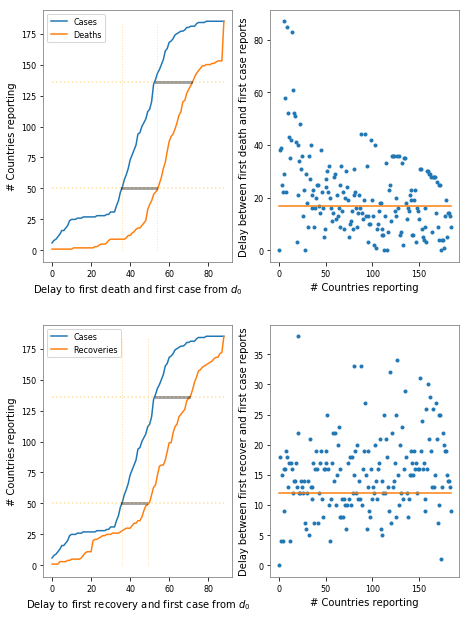

In [25]:
# 
a = 50; b = 136
ia_cumC = np.where(cumC>a)[0].min()
ia_cumD = np.where(cumD>a)[0].min()-1
ib_cumC = np.where(cumC>b)[0].min()
ib_cumD = np.where(cumD>=b)[0].min()
ia_cumR = np.where(cumR>a)[0].min()-1
ib_cumR = np.where(cumR>=b)[0].min()
aa=ia_cumD-ia_cumC
bb=ib_cumD-ib_cumC
cc=ia_cumR-ia_cumC
dd=ib_cumR-ib_cumC
print(ib_cumC, ib_cumR, cc,dd)
print(ia_cumC,ib_cumC,ia_cumD,ib_cumD)
delaysFDC =sdFD-sdFC
delaysFRC =sdFR-sdFC
#
fRepDelay= gr.figure(figsize=(7,9)); gr.ioff()
rows=2; cols=2
ax=fRepDelay.add_subplot(rows,cols,1); 
bx=fRepDelay.add_subplot(rows,cols,2); 
cx=fRepDelay.add_subplot(rows,cols,3); 
dx=fRepDelay.add_subplot(rows,cols,4); 
days = np.arange(nDays)
cC = np.arange(nCountries)
ticks= np.arange(0,nDays,7)
bx.plot(cC, delaysFDC, '.', label='#case-death ')
bx.plot(cC, mm*np.ones(nCountries),label=r'%d days'%delaysFDC.mean())
dx.plot(cC, delaysFRC, '.', label='#case-death ')
dx.plot(cC, MM*np.ones(nCountries),label=r'%d days'%delaysFRC.mean())
ax.plot(days,cumC,label='Cases')
ax.plot(days,cumD, label='Deaths')
cx.plot(days,cumC,label='Cases')
cx.plot(days,cumR, label='Recoveries')
ax.plot(days,a*np.ones(nDays),':',color='orange',alpha=0.35)
ax.plot(days,b*np.ones(nDays),':',color='orange',alpha=0.35)
cx.plot(days,a*np.ones(nDays),':',color='orange',alpha=0.35)
cx.plot(days,b*np.ones(nDays),':',color='orange',alpha=0.35)
ax.plot( [days[ia_cumC],days[ia_cumC]], [cC[0],cC[-1]],':',color='orange',lw=1,alpha=0.35)
ax.plot( [days[ia_cumD],days[ia_cumD]], [cC[0],cC[-1]],':',color='orange',lw=1,alpha=0.35)
ax.plot( days[ib_cumC:ib_cumD], b*np.ones(bb),'k',lw=3,alpha=0.35)
ax.plot( days[ia_cumC:ia_cumD], a*np.ones(aa),'k',lw=3,alpha=0.35)
cx.plot( [days[ia_cumC],days[ia_cumC]], [cC[0],cC[-1]],':',color='orange',lw=1,alpha=0.35)
cx.plot( [days[ia_cumR],days[ia_cumR]], [cC[0],cC[-1]],':',color='orange',lw=1,alpha=0.35)
cx.plot( days[ib_cumC:ib_cumR], b*np.ones(dd),'k',lw=3,alpha=0.35)
cx.plot( days[ia_cumC:ia_cumR], a*np.ones(cc),'k',lw=3,alpha=0.35)
str1='Delay between first death and first case reports'
str3='Delay between first recover and first case reports'
str2='# Countries reporting'
str4='# Countries reporting'
bx.set_ylabel(str1); dx.set_ylabel(str3)
ax.set_xlabel(r'''Delay to first death and first case from $d_0$''')
cx.set_xlabel(r'''Delay to first recovery and first case from $d_0$''')
bx.set_xlabel(str2); dx.set_xlabel(str2)
ax.set_ylabel(str2); cx.set_ylabel(str4)
ax.legend(loc='upper left')
cx.legend(loc='upper left')
gr.ion(); gr.draw()
fRepDelay.subplots_adjust(left=0.075,bottom=0.075,right=0.9,top=0.95,wspace=0.2,hspace=0.25)
fRepDelay.savefig('./figures/tsam_Covid19_JHU_delays_caseDeaths.png')

#print(aa,bb)

Now a comparison between those estimates of delays and the delays (not just the first case from the whole world)

In [26]:
days = np.arange(nDays)
qs = np.arange(0,1,0.01)
delaysFDC = sdFD-sdFC
qDelaysFDC = np.quantile(delaysFDC,qs)
print('Quantiles for delays D-C:',qDelaysFDC)
medianFDCdelay = np.int32(np.median(delaysFDC) )
print('The median delay between first death and first case is %d days'%medianFDCdelay)
print('The mode of the distribution for first death and case delays is %d'% findMode(dFD-dFC))
print('The mode of the distribution for first recovery and case delays is %d'% findMode(dFR-dFC))
print(np.sort(sdFD-sdFC))
print(np.sort(sdFR-sdFC))

('Quantiles for delays D-C:', array([ 0.  ,  0.  ,  0.  ,  1.  ,  2.  ,  3.  ,  3.  ,  3.88,  4.  ,
        4.56,  5.  ,  5.24,  6.  ,  6.  ,  6.76,  7.  ,  8.  ,  8.  ,
        8.  ,  8.96,  9.  ,  9.  ,  9.  , 10.  , 10.  , 11.  , 11.  ,
       12.  , 12.  , 13.  , 13.  , 13.  , 13.  , 13.  , 14.  , 14.  ,
       14.  , 14.08, 15.  , 15.  , 15.  , 16.  , 16.  , 16.  , 16.  ,
       16.  , 16.  , 17.48, 18.  , 18.16, 19.  , 19.  , 19.  , 20.  ,
       20.  , 21.  , 21.  , 21.  , 21.72, 22.  , 22.  , 22.24, 23.  ,
       23.  , 23.76, 24.6 , 25.  , 25.  , 25.  , 25.96, 27.  , 28.  ,
       28.  , 28.32, 29.  , 29.  , 29.84, 30.  , 30.52, 31.  , 31.2 ,
       32.  , 32.88, 33.72, 35.  , 35.4 , 36.  , 36.  , 36.  , 37.52,
       38.6 , 40.  , 40.28, 42.  , 42.96, 44.  , 49.92, 52.  , 58.96,
       83.32]))
The median delay between first death and first case is 19 days
The mode of the distribution for first death and case delays is 36
The mode of the distribution for first recovery and ca

IndexError: invalid index to scalar variable.

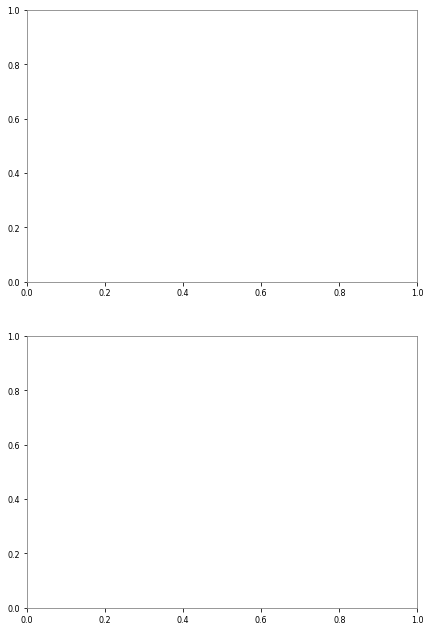

In [81]:
# Diagrama de Poincaré
cols=1
fPoincare= gr.figure(figsize=(7,11)); gr.ioff()
axCD=fPoincare.add_subplot(2,cols,1)
axCR=fPoincare.add_subplot(2,cols,2)
mCDerror=10**8; mCRerror=10**8

le=30;ri=125; colors = ['blue','green','orange','red','magenta']
ii = np.where( (cumC>le) & (cumC<ri) )[0];
jj = np.where( (cumC<le) | (cumC>ri) )[0]
delay = 18
cumCmain=cumC[ii]; cumD[ii+delay]
cumCout=cumC[jj]
ee=0; ff=0
offsets = np.int32(np.arange(16,21)); 
for n in range(len([offsets])):
    o1 = offsets[n]
    for m in range(o1[n],len(ii)-o1):
        axCD.plot(cumC[m],cumD[m+o1],'.'+colors[n]) 
        ee=ee+np.absolute(cumC[ii]-cumD[m+o1])**2
    if mCDerror>ee:
        offsetCD= o1 
    for m in range(o1,len(jj)-o1):
        axCD.plot(cumC[m],cumD[m+o1],'k.',alpha=0.35) 

offsets = np.int32(np.arange(12,17)); 
for n in len(offsets):
    o2 = offsets[n]
    for m in range(o2,len(ii)-o2):
        axCR.plot(cumC[m],cumR[m+o2],'.')
        ff=ff+ np.absolute(cumC[ii]-cumR[a])**2
    if mCRerror>ff:
        offsetCR= o2
    for m in range(o2,len(jj)-o2):
        axCR.plot(cumC[m],cumR[m+o2],'k.',alpha=0.35)

axCD.plot([0,nCountries],[0,nCountries],'k:',alpha=0.35)
axCR.plot([0,nCountries],[0,nCountries],'k:',alpha=0.35)
axCD.legend(loc='lower right'); axCR.legend(loc='lower right')
axCD.set_xlabel('Cumulative # countries reporting cases')
axCD.set_ylabel('Cumulative # countries reporting deaths')
axCR.set_xlabel('Cumulative # countries reporting cases')
axCR.set_ylabel('Cumulative # countries reporting recoveries')
gr.ion(); gr.draw(); gr.show()

print('Deaths occur on average %d days after case detection'%offsetCD)
print('Recoveries occur on average %d days after case detection'%offsetCR)
print(cumC[ii])
print(cumD[ii+offsetCD])
print(cumR[ii+offsetCR])

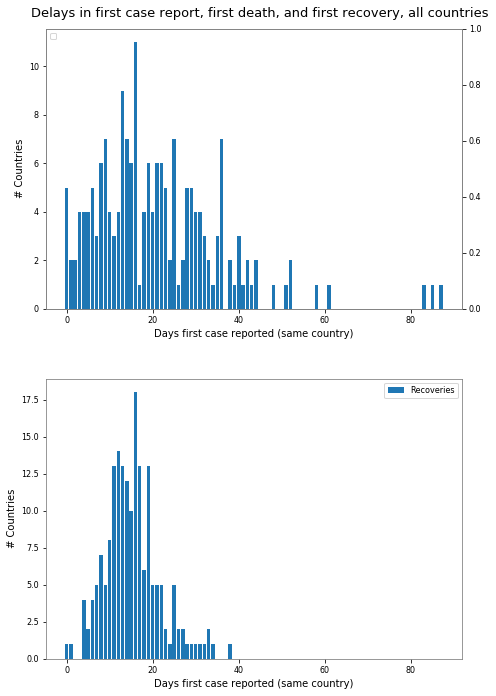

In [32]:
#cFirstCases, binsC = np.histogram(dFC,np.arange(0,(iFD-iFC).max()))
days = np.arange(nDays)
cDelayDeaths2Case, binsD = np.histogram(dFD-dFC,days)
cDelayRecovs2Case, binsR = np.histogram(dFR-dFC,days)
days = np.arange(nDays)

def plotReportingDelays():
    fDelays= gr.figure(figsize=(7,10)); gr.ioff(); rows=2; cols=1;
    ticks = np.arange(0,nDays,7)
    ax=list(); tAx=list()
    fDelays.suptitle('Delays in first case report, first death, and first recovery, all countries')
    for m in range(rows*cols):
        ax.append(fDelays.add_subplot(rows,cols,m+1))
    tAx.append(ax[0].twinx())
    ax[0].bar(binsD[:-1],cDelayDeaths2Case,width=0.8,label='Deaths')
    ax[1].bar(binsR[:-1],cDelayRecovs2Case,width=0.8,label='Recoveries')
    #
    ax[0].set_xlabel('Days first case reported (same country)')
    ax[1].set_xlabel('Days first case reported (same country)')

    for m in range(rows*cols):
        #ax[m].set_yticks(np.arange(0,np.maximum(cDelayRecovs2Case.max()+1,cumC.max()),2))
        ax[m].set_ylabel('# Countries',rotation=90)
        if m>0:
            ax[m].legend(loc='upper right')
        if m<1:
            tAx[m].legend(loc='upper left')
    fDelays.subplots_adjust(left=0.075,bottom=0.075,right=0.9,top=0.95,wspace=0.1,hspace=0.25)
    gr.ion(); gr.draw(); gr.show()
    fDelays.savefig('figures/tsam_Covid19_JHU_delays_AllCountries.png')
    return fDelays

fDelays= plotReportingDelays()

In [36]:
n=10; print(r'%d countries reported within the first %d days from $d_0$'%(len(sdFC[sdFC<n+1]),n))
countries[iArrival[sdFC<n+1]]

25 countries reported within the first 10 days from $d_0$


array(['China', 'US', 'Thailand', 'Taiwan*', 'Japan', 'Korea, South',
       'Vietnam', 'Singapore', 'France', 'Nepal', 'Malaysia', 'Canada',
       'Australia', 'Germany', 'Cambodia', 'Sri Lanka', 'Finland',
       'United Arab Emirates', 'India', 'Philippines', 'Sweden', 'Italy',
       'United Kingdom', 'Russia', 'Spain'], dtype=object)

In [37]:
n=30; print(r'%d countries reported within the first %d days from $d_0$'%(len(sdFC[sdFC<n+1]),n))
countries[iArrival[sdFC<n+1]]

31 countries reported within the first 30 days from $d_0$


array(['China', 'US', 'Thailand', 'Taiwan*', 'Japan', 'Korea, South',
       'Vietnam', 'Singapore', 'France', 'Nepal', 'Malaysia', 'Canada',
       'Australia', 'Germany', 'Cambodia', 'Sri Lanka', 'Finland',
       'United Arab Emirates', 'India', 'Philippines', 'Sweden', 'Italy',
       'United Kingdom', 'Russia', 'Spain', 'Belgium', 'Diamond Princess',
       'Egypt', 'Iran', 'Israel', 'Lebanon'], dtype=object)

## Cases vs deaths in some subsets of countries taking the delay into account

In [38]:
# -------------------
# Search regions to illustrate the case-fatality ratios
# -------------------
Pops_Millions = {'China':1439323776, 'Japan':126476461,'Korea, South':51269185, 'Indonesia':273523615, 
                 'Singapore':5850342, 'Mexico':128932753,'US':331002651, 'Canada':37742154, 'Argentina':45195774,
                 'Brazil':212559417, 'Colombia':50882891, 'Niger':24206644, 'Algeria':43851044, 'Egypt':102334404, 
                 'South Africa':59308690,'Spain':46754778,'Italy':60461826,'France':67886011,'Germany':83783942, 
                 'Australia':25499884,'United Kingdom':67886011,'Iran':83992949,'Israel':8655535}

In [42]:
#
def plotCasesDeathsTS(casesTS,deathsTS,regions,countries, convFactor=1000,saveFig=1):
    ii = getIndsRegions(countries, regions)
    figu= gr.figure(figsize=(7,9))
    if convFactor <= 1000:
        figu.suptitle('Deaths vs cases per {: d} habitants'.format(convFactor))
    elif convFactor == 10**6:
        figu.suptitle('Deaths vs cases per million ')
    gr.ioff(); ax=list(); sax=list(); cols=1; rows =3
    ticks= np.arange(0,nDays,7)
    for n in range(len(regions)):
        ax.append(figu.add_subplot(rows,cols,n+1))
        sax.append(inset_axes(parent_axes=ax[n],
                                width="30%", # width = 30% of parent_bbox
                                height="30%", # height : 1 inch
                                loc='lower right'))
        region=ii[n]
        if convFactor <= 1000:
            strDeaths = 'Deaths x {: d}'.format(convFactor)
        elif convFactor == 10**6:
            strDeaths = 'Deaths per million'
        for nn in range(len(region)):
            cas=convFactor*np.float64(casesTS[region[nn]]) /Pops_Millions[countries[region[nn]]]
            dea=convFactor*np.float64(deathsTS[region[nn]]) /Pops_Millions[countries[region[nn]]]
            sax[n].plot(cas,dea,'-',label=countries[region[nn]])
            ax[n].plot(cas,dea,'-',label=countries[region[nn]])
            if convFactor <= 1000:
                ax[n].set_xlabel(r'cases x %d'%convFactor);  ax[n].set_ylabel(r'deaths x %d'%convFactor)
            elif convFactor == 10**6: 
                ax[n].set_xlabel(r'cases per million');  ax[n].set_ylabel(r'deaths per million')
        ymm= ax[n].get_ylim()[1]/3
        xmm= ax[n].get_xlim()[1]/3
        sax[n].set_ylim(0.0,ymm);  sax[n].set_xlim(0.0,xmm);sax[n].set_xticklabels([])
        ax[n].legend(ncol=3,loc='upper left',fontsize=8)
    figu.subplots_adjust(left=0.075,bottom=0.075,right=0.97,top=0.95,wspace=0.2,hspace=0.25)
    gr.ion(); gr.draw(); gr.show()
    if saveFig>0:
        figName='figures/tsam_Covid19_JHU_cases-deaths_x%d_JHU.png'%convFactor
        figu.savefig('./'+figName)
    return figu


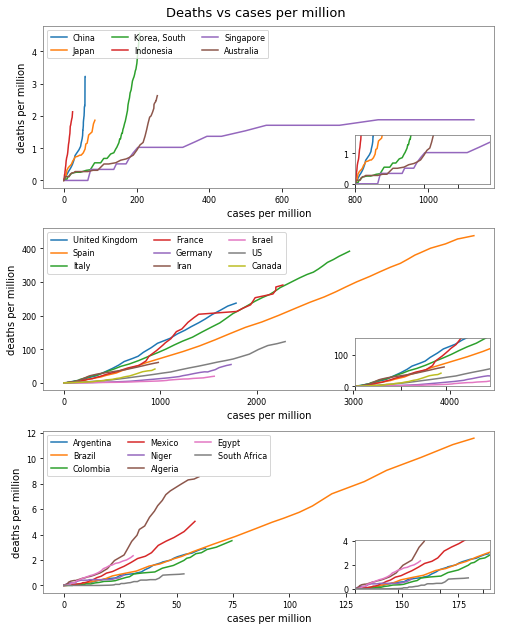

In [43]:
# Setup regions
R1=['China','Japan','Korea, South','Indonesia','Singapore','Australia']
R2=['United Kingdom','Spain','Italy','France','Germany']
#America=['Mexico','US','Argentina','Brazil','Colombia','Chile']
LatinAmerica=['Argentina','Brazil','Colombia','Mexico']
Africa=['Niger','Algeria','Egypt','South Africa']
R3=['US','Canada']
MiddleEast =['Iran','Israel']
#MiddleEast =['Iran','Lebanon', 'West Bank and Gaza','Israel']
regions=[R1,R2+MiddleEast+R3,LatinAmerica+Africa]
#
ii = getIndsRegions(countries, regions)
figu=plotCasesDeathsTS(casesTS=totCases,deathsTS=totDeathCases,regions=regions,countries=countries, convFactor=10**6)



## Case-fatality ratios 

The case fatality ratio is an approximation for the probability of death among cases in an epidemic. In fact, it is an upper bound for the proportion of deaths due to infection, assuming that people that have not been confirmed do not have a higher probability of dying because of the infection.

The case-fatality ratios can be calculated by dividing each entry in the deaths data frame, by the corresponding entry in the cases data frame.


In [44]:
def delayCorrectTSPair(a,b,delay=18):
    nPts = len(a)
    a = a[:-DCdelay]
    b = b[DCdelay:]
    return a,b

DCdelay=14; DRdelay=14
DC_totCases,DC_totDeaths=delayCorrectTSPair(totCases.transpose(),totDeathCases.transpose(),delay=DCdelay)
RC_totCases,RC_totRecovs=delayCorrectTSPair(totCases.transpose(),totRecovCases.transpose(),delay=DRdelay)
#
DC_totCases = DC_totCases.transpose()
DC_totDeaths= DC_totDeaths.transpose()
RC_totCases = RC_totCases.transpose()
RC_totRecovs= RC_totRecovs.transpose()

In [45]:
def zeroCorrectCFR(c,d):
    c[c==0]=1
    print(c.shape,d.shape)
    return d/c

print(totCases.shape,totDeathCases.shape)
print(DC_totCases.shape,DC_totDeaths.shape)
cfr=zeroCorrectCFR(c=np.float64(totCases),d=totDeathCases)
DC_cfr=zeroCorrectCFR(c=np.float64(DC_totCases),d=DC_totDeaths)
print(cfr.shape,DC_cfr.shape)

DC_cfr.max()

((185, 89), (185, 89))
((185, 75), (185, 75))
((185, 89), (185, 89))
((185, 75), (185, 75))
((185, 89), (185, 75))


77.0

In [46]:
# Local example for comparison of CFRs with and without delay
DCdelay =0
i = np.where(countries=='Spain')[0][0]
locCases = totCases[i]
locDeaths = totDeathCases[i]
DC_locCases= locCases[:-DCdelay]
DC_locDeaths= locDeaths[DCdelay:]
print(DC_locCases,DC_locDeaths)
DC_locCFR =zeroCorrectCFR(c=np.int64(DC_locCases),d=DC_locDeaths)
fLocalDC= gr.figure(figsize=(7,11)); 
gr.ioff(); ax=list(); rows=4; cols=1
for n in range(rows*cols):
    ax.append(fLocalDC.add_subplot(rows,cols,n+1))
    
delayDays = np.arange(DCdelay,nDays)
ax[0].plot(DC_locCases,DC_locDeaths,label='(C,D) delay-corrected, %s'%countries[i]) 
ax[0].plot(locCases[DCdelay:],locDeaths[DCdelay:],label='(C,D) no correction, %s'%countries[i])
ax[1].plot(delayDays,DC_locCases,label='shifted cases')
ax[1].plot(delayDays,DC_locDeaths,label='deaths')
ax[2].plot(delayDays[1:],DC_locCases[1:]-DC_locCases[:-1],label=r'$\Delta$ cases')
ax[2].plot(delayDays[1:],DC_locDeaths[1:]-DC_locDeaths[:-1],label=r'$\Delta$ deaths')
ax[3].plot(delayDays[1:],DC_locCFR,label=r'$\frac{D(t+\delta)}{C(t)}$')

for n in range(rows*cols):
    ax[n].legend()
gr.ion(); gr.draw()

(array([], dtype=int64), array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     1,     2,     3,     5,
          10,    17,    28,    35,    54,    55,   133,   195,   289,
         342,   533,   623,   830,  1043,  1375,  1772,  2311,  2808,
        3647,  4365,  5138,  5982,  6803,  7716,  8464,  9387, 10348,
       11198, 11947, 12641, 13341, 14045, 14792, 15447, 16081, 16606,
       17209, 17756, 18056, 18708, 19315, 20002, 20043, 20453]))
((0,), (89,))


ValueError: operands could not be broadcast together with shapes (89,) (0,) 

Search regions to illustrate the case-fatality ratios

Function to plot the CFR in different subsets of countries chosen specifically to illustrate different dynamics

In [47]:
#
def plotCFRTS(cfr,dates,regions,countries,move2start=1):
    cfr=100*cfr
    delayDays = np.arange(DCdelay,nDays)
    ii = getIndsRegions(countries, regions)
    figu = gr.figure(figsize=(7,9))
    figu.suptitle('Percentage of dead/confirmed between %s-%s'''%(dates[0],dates[-1]))
    ax=list(); gr.ioff()
    cols=1; rows = 3
    ticks= np.arange(0,nDays,7)
    for n in range(len(regions)):
        ax.append(figu.add_subplot(rows,cols,n+1))
        region=ii[n];
        for nn in range(len(region)):
            thisCFR=cfr[region[nn]]
            ax[n].set_xticks(ticks)
            if move2start:
                startInd = np.maximum( np.where(thisCFR>0)[0].min(),0)
                ax[n].plot(thisCFR[startInd:],'-',label=countries[region[nn]])
                ax[n].set_xlabel('Days from first reported case')
            else:
                ax[n].plot(cfr[region[nn]],'-',label=countries[region[nn]])
                ax[n].set_xticklabels(dates[ticks],{'fontsize':8})
                for label in ax[n].get_xticklabels():
                    label.set_rotation(45)
                    label.set_horizontalalignment('center')
                    label.set_fontsize(8)
        #ax[n].set_xlim(ximin,len(dates))
        ax[n].set_ylim(0,15);
        ax[n].legend(ncol=4,loc='upper left',fontsize=8)
    figu.subplots_adjust(left=0.075,bottom=0.075,right=0.97,top=0.95,wspace=0.2,hspace=0.25)
    gr.ion(); gr.draw(); gr.show()
    return figu

Now let us plot the case fatality ratios of a few countries with reported cases. 

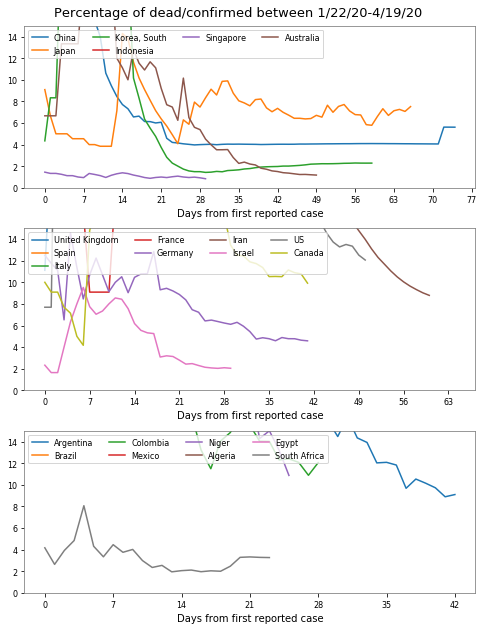

In [48]:
# ---------------------------------------------
# All relative to the starting days of the pandemia
figu=plotCFRTS(DC_cfr,dates,regions,countries, move2start=1)
strCFR='figures/tsam_Covid19_JHU_cfr_fromFirstLocalCase.png'
figu.savefig('./'+strCFR)


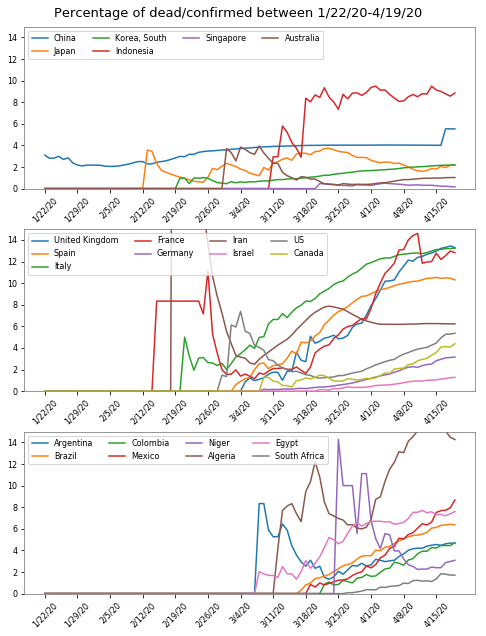

In [49]:
# ---------------------------------------------
# From the day the first case was reported
figu=plotCFRTS(cfr,dates,regions,countries, move2start=0)
strCFR='figures/tsam_Covid19_JHU_cfr_relative2d0.png'
figu.savefig('./'+strCFR)
# ---------------------------------------------


It is important to consider that the first few reports of deaths usually are biased by the fact that those cases are almost 

### Case fatality ratios in detail for countries reporting cases by province

The countries where there are reports by province are China, United Kingdom, Australia, and Canada. To see this, print the list of countries including repetitions.

In [50]:
countries_Cases

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Australia', 'Australia', 'Australia', 'Australia', 'Australia',
       'Australia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas',
       'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
       'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burma', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Canada', 'Canada', 'Canada', 'Canada', 'Canada', 'Canada',
       'Canada', 'Canada', 'Canada', 'Canada', 'Canada', 'Canada',
       'Canada', 'Canada', 'Central African Republic', 'Chad', 'Chile',
       'China', 'China', 'China', 'China', 'China', 'China', 'China',
       'China', 'China', 'China', 'China', 'China', 'China', 'China',
       'China', 'China', 'China', 'China', 'China', 'China', 'China',
       'China', 'China', 'Chin

The rows that contain the data from China, for instance, are between 42 and 82, inclusive.

### CFR analysis for China, UK, and Australia, taking into account the data by province

The data will be separated into dictionaries, one for each country. 

China

In [51]:
China= {'Country name':'China'}
China['cfrWC']=cfr[np.where(countries=='China')[0][0]]
China['cases'], China['indsCases']= gatherDataSingleCountry(cases,'China')
China['deathCases'], China['indsDeaths']= gatherDataSingleCountry(deathCases,'China')
China['cfrs'] = correctedArrayRatio(China['deathCases'],China['cases'])
China['provinces']=cases.iloc[China['indsCases'],0].to_numpy()
China['nProvinces'] = len(China['provinces'])
China['startDaysCases']= findCaseStarts(places=China['provinces'],cases=China['cases'])

UK

In [52]:
UK =  {'Country name':'UK'}
UK['cfrWC']=cfr[np.where(countries=='United Kingdom')[0][0]]
UK['cases'], UK['indsCases']= gatherDataSingleCountry(cases,'United Kingdom')
UK['deathCases'], UK['indsDeaths']= gatherDataSingleCountry(deathCases,'United Kingdom')
UK['cfrs'] = correctedArrayRatio(UK['deathCases'],UK['cases'])
UK['provinces']=cases.iloc[UK['indsCases'],0].to_numpy()
UK['nProvinces'] = len(UK['provinces'])
UK['startDaysCases']= findCaseStarts(places=UK['provinces'],cases=UK['cases'])
print(UK['provinces'])
UK['provinces'][6]= 'Great Britain'
print(UK['provinces'])

['Bermuda' 'Cayman Islands' 'Channel Islands' 'Gibraltar' 'Isle of Man'
 'Montserrat' nan 'Anguilla' 'British Virgin Islands'
 'Turks and Caicos Islands' 'Falkland Islands (Malvinas)']
['Bermuda' 'Cayman Islands' 'Channel Islands' 'Gibraltar' 'Isle of Man'
 'Montserrat' 'Great Britain' 'Anguilla' 'British Virgin Islands'
 'Turks and Caicos Islands' 'Falkland Islands (Malvinas)']


Australia

In [53]:
Australia =  {'Country name':'Australia'}
Australia['cfrWC']=cfr[np.where(countries=='Australia')[0][0]]
Australia['cases'], Australia['indsCases']= gatherDataSingleCountry(cases,'Australia')
Australia['deathCases'], Australia['indsDeaths']= gatherDataSingleCountry(deathCases,'Australia')
Australia['cfrs'] = correctedArrayRatio(Australia['deathCases'],Australia['cases'])
Australia['provinces']=cases.iloc[Australia['indsCases'],0].to_numpy()
Australia['nProvinces'] = len(Australia['provinces'])
Australia['startDaysCases']= findCaseStarts(places=Australia['provinces'],cases=Australia['cases'])

In [ ]:
Australia['startDaysCases']

Plot comparisons for the three places with averages by region and comparison with the whole country average

In [54]:
def plotCFRTS_Provinces(place,dates,move2start=1):
    figu = gr.figure(figsize=(7,5))
    figu.suptitle('Percentage of dead/confirmed between %s-%s in %s'''%(dates[0],dates[-1],place['Country name']))
    gr.ioff();cols=1; rows = 1
    ax=figu.add_subplot(rows,cols,1)
    print(place['Country name'])
    ticks= np.arange(0,nDays,7)
    si = place['startDaysCases'].min()
    for nn in range(len(place['provinces'])):
        #print(place['provinces'][nn])
        thisCFR=100*place['cfrs'][nn]
        ax.set_xticks(ticks)
        if move2start==1:
            ax.plot(thisCFR[si:],'-',label=place['provinces'][nn])
            ax.set_xlabel('Days from first reported case')
        else:
            ticks= np.arange(si,nDays,7)
            ax.plot(thisCFR,'-',label=place['provinces'][nn])
            ax.set_xticklabels(dates[ticks],{'fontsize':8})
            for label in ax.get_xticklabels():
                label.set_rotation(0)
                label.set_horizontalalignment('center')
                label.set_fontsize(8)
    avgCFR=100*place['cfrs'].mean(0)
    if move2start==1:
        ax.plot(avgCFR[si:],'k-',alpha=1, lw=3,label='Average CFR from provinces in %s'%place['Country name'])
        ax.plot(100*place['cfrWC'][si:],'k-',alpha=0.35, lw=5,label='CFR from total cases')
        strCFR='figures/tsam_Covid19_JHU_cfr_Provinces'+place['Country name']+'_fromDate0.png'
    else:
        ax.plot(avgCFR,'k-',alpha=1, lw=3,label='Average CFR from provinces in %s'%place['Country name'])
        ax.plot(100*place['cfrWC'],'k-',alpha=0.35, lw=5,label='CFR from total cases')
        strCFR='figures/tsam_Covid19_JHU_cfr_Provinces'+place['Country name']+'_fromFirstLocalReport.png'
    ax.set_ylim(0,10);
    ax.legend(ncol=4,loc='upper center',fontsize=8)
    figu.subplots_adjust(left=0.075,bottom=0.075,right=0.97,top=0.92,wspace=0.2,hspace=0.25)
    figu.savefig('./'+strCFR)
    gr.ion(); gr.draw(); gr.show()
    return figu

China


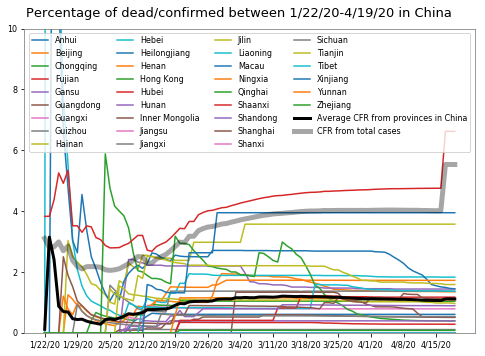

In [55]:
figuChina=plotCFRTS_Provinces(China,dates,move2start=0)

UK


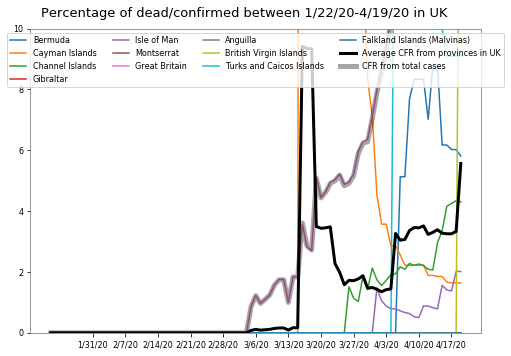

['Bermuda' 'Cayman Islands' 'Channel Islands' 'Gibraltar' 'Isle of Man'
 'Montserrat' 'Great Britain' 'Anguilla' 'British Virgin Islands'
 'Turks and Caicos Islands' 'Falkland Islands (Malvinas)']


In [56]:
figuUK=plotCFRTS_Provinces(UK,dates,move2start=0)
print(UK['provinces'])

Australia


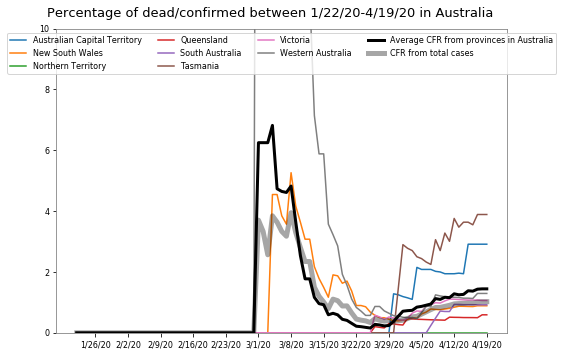

In [57]:
figuAust=plotCFRTS_Provinces(Australia,dates,move2start=0)

### Predictions of CFR by age groups based on estimates from China and Italy

The rates of mortality among cases by age group have been reported in some of the countries where COVID-19 has been detected.  The probability that a person with positive SARS-CoV-2 testing dies in the hospital depends on many different factors. Some of these factors depend on the individual, including age, comorbidities like hypertension, obesity and diabetes, etcetera [(10.1016/S0140-6736(20)30566-3)](https://www.sciencedirect.com/science/article/pii/S0140673620305663). Other factors hinge on the availability of health care, and the quality of care in different countries.  Of note, the mortality in Italy, South Korea, and China, are constrasting cases of study of the known patterns patterns for CFRs results due to different conditions in these countries, different population structures, and health care policies. 

As a means to generate estimates of the CFRs from different age groups, we propose a simple calculation of proportions based on cases. Depending on an unknown factor that would account for under reporting, these estimates can be used to generate time series of CFRs by age. 

The age groups to take into account are \[0,10),\[10,20), \[20,30), \[30,40), \[40,50), \[50,60), \[60,70), \[70,80), 80+. 

The data that will be used was last estimated in February 11, 2020 for China, March 17, 2020, for Italy, and March 24, 2020 for South Korea [(video of Kim Woo-Joo from the Guro University Hospital Guro, University of Korea (March 27, 2020)](https://www.youtube.com/watch?v=gAk7aX5hksU&feature=youtu.be).

There are reports of up to 20% of symptomatic cases, and in South Korea, for instance, about 50% of hospitalizations are people 60 years old or older, it is important to obtain numbers to estimate the size of a population in need for critical care. 

In [58]:
SKorea={'ageCFR': np.array([0,0,0,0.001,0.001,0.004,0.015,0.063,0.116]),'CFR_20200324':0.02,'Country name':'Korea, South'}
Italy={'ageCFR': np.array([0,0,0,0.003,0.004,0.01,0.035,0.128,0.202]),'CFR_20200317':0.072,'Country name':'Italy'}
China['ageCFR'] = np.array([0,0.002,0.002,0.002,0.004,0.013,0.036,0.08,0.14])
China['CFR_20200211'] = 0.02
aGroups=np.arange(0,90,10)


In [59]:
def sigmoid(a, aMax=0.1,a0=60.0,n=2): 
    aa = a**n
    return aMax* aa /(aa + a0**n)

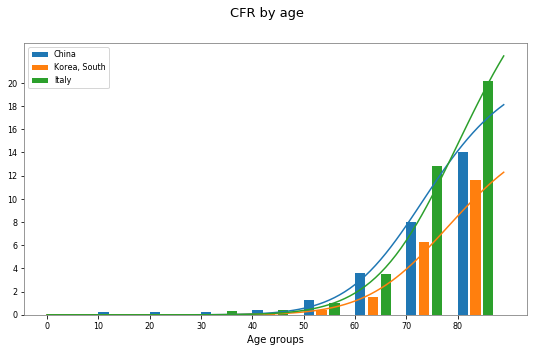

In [61]:
ageCountries=[China, SKorea, Italy]
ages = np.arange(0,90)
f11=gr.figure(figsize=(9,5)); gr.ioff(); rows =1;cols=1
f11.suptitle('CFR by age')
lshift=2.5;  ax=f11.add_subplot(rows,cols,1)
for n in range(len(ageCountries)):
    ax.bar(aGroups+ (n*lshift), 100*ageCountries[n]['ageCFR'],width=2,align='edge',label=ageCountries[n]['Country name']);
ax.plot(ages, 100*sigmoid(a=ages,a0=75,aMax=0.22,n=9))
ax.plot(ages, 100*sigmoid(a=ages,a0=80,aMax=0.17,n=9))
ax.plot(ages, 100*sigmoid(a=ages,a0=82,aMax=0.33,n=9))
ax.legend(loc='upper left')
ax.set_xticks(aGroups)
ax.set_yticks(np.arange(0,20+1,2))
ax.set_xlabel('Age groups')
gr.ion(); gr.draw();  gr.show()
f11Name='figures/tsam_Covid19_JHU_cfrByAge_China+SKorea+Italy.png'
f11.savefig(f11Name)


These profiles are similar in that they are all increasing as a function of age, reaching a half-maximum height at ages between 50 and 60 years of age. 

We can establish qualitative estimations of the percentage of deaths based on these age CFRs. To do so, we calculate the weights of the CFRs in each age group, which represent the proportion of deaths in each group.

#### Calculation of proportions of death within cases, by age groups

Let $c_i$ represent the case-fatality ratio in $i$th age group, $i \in \left\{0,1,...,8\right\}$
The weight of the $i$th age group on the total death reported via CFRs is
$$w_i = \frac{c_i}{\sum_{j=0}^{n-1}} w_j.$$
Then the probability of death in the $i$th age group can be estimated by multiplying the CFR and the weight of the $i$th age group on the CFR. Then, multiplication by the number of cases would yield the death toll by age group. 
 

A few sutile differences can be noted from these data. For instance, the CFRs for the first 3 groups in Italy and South Korea are very similar. In Italy, the percentage of dead cases is very large among the last two age groups, which in part is due to the fact that Italians implemented a triage system that sometimes denied respirators to patients with small chances of survival. 

In [64]:
ageCountries=[China,SKorea,Italy]
for n in range(len(ageCountries)):
    C = ageCountries[n]
    print(C['Country name'])
    ageCFRweights = C['ageCFR'].sum()
    C['ageDeadCaseProps'] = C['ageCFR']/ageCFRweights
    C['cfrTotCases']=cfr[np.where(countries==C['Country name'])[0][0]]
    C['totCases'] = totCases[np.where(countries==C['Country name'])[0][0]]
    C['totDeathCases'] = totDeathCases[np.where(countries==C['Country name'])[0][0]]
    C['totDeathCases_ageProps'] = np.zeros((len(aGroups),len(C['totDeathCases'])),'int64')
    for nn in range(len(aGroups)):
        C['totDeathCases_ageProps'][nn,:]= C['ageDeadCaseProps'][nn] * C['totCases']* C['cfrTotCases']
        print(C['totDeathCases_ageProps'][nn])



China
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  1  1  1  2  3  3  4  4  5  5  6  7  7  8  9 10
 11 12 13 14 15 16 16 17 17 18 19 19 19 19 20 20 20 21 21 21 21 22 22 22
 22 22 22 22 22 22 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23
 23 23 23 23 23 23 23 23 23 23 23 23 23 23 33 33 33]
[ 0  0  0  0  0  0  0  0  1  1  1  2  3  3  4  4  5  5  6  7  7  8  9 10
 11 12 13 14 15 16 16 17 17 18 19 19 19 19 20 20 20 21 21 21 21 22 22 22
 22 22 22 22 22 22 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23
 23 23 23 23 23 23 23 23 23 23 23 23 23 23 33 33 33]
[ 0  0  0  0  0  0  0  0  1  1  1  2  3  3  4  4  5  5  6  7  7  8  9 10
 11 12 13 14 15 16 16 17 17 18 19 19 19 19 20 20 20 21 21 21 21 22 22 22
 22 22 22 22 22 22 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23
 23 23 23 23 23 23 23 23 23 23 23 23 23 23 33 33 

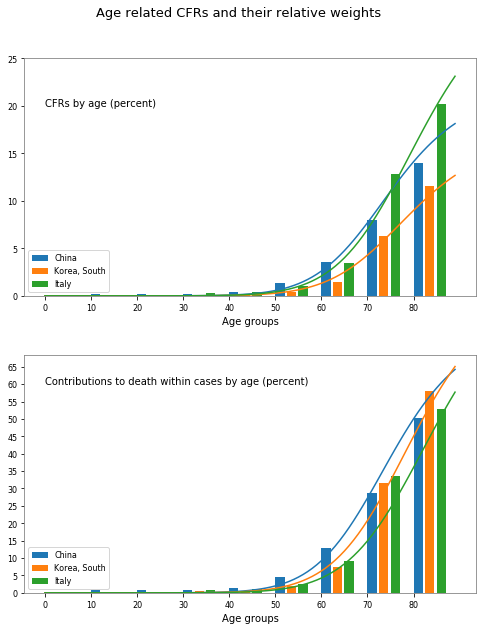

In [78]:
ages = np.arange(0,90)
f10b=gr.figure(figsize=(7,9)); gr.ioff(); rows =2;cols=1
f10b.suptitle('Age related CFRs and their relative weights'); ax=list()
for m in range(rows*cols):
    ax.append(f10b.add_subplot(rows,cols,m+1))
lshift=2.5;  
for n in range(len(ageCountries)):
    C=ageCountries[n]
    ax[0].bar(aGroups+ (n*lshift), 100*C['ageCFR'],width=2,align='edge',label=ageCountries[n]['Country name']);
    ax[1].bar(aGroups+ (n*lshift), 100*C['ageDeadCaseProps'],width=2,align='edge',label=ageCountries[n]['Country name']);
ax[0].plot(ages, 100*sigmoid(a=ages,a0=75,aMax=0.22,n=9))
ax[0].plot(ages, 100*sigmoid(a=ages,a0=79,aMax=0.17,n=9))
ax[0].plot(ages, 100*sigmoid(a=ages,a0=81,aMax=0.33,n=9))
ax[1].plot(ages, 100*sigmoid(a=ages,a0=75,aMax=0.78,n=9))
ax[1].plot(ages, 100*sigmoid(a=ages,a0=80,aMax=0.9,n=9))
ax[1].plot(ages, 100*sigmoid(a=ages,a0=84,aMax=0.92,n=9))
for m in range(rows*cols):
    ax[m].legend(loc='lower left'); 
    ax[m].set_xticks(aGroups)
    ax[m].set_xlabel('Age groups')
ax[0].set_yticks(np.arange(0,26,5))
ax[1].set_yticks(np.arange(0,66,5))
ax[0].text(0,20,'CFRs by age (percent)')
ax[1].text(0,60,'Contributions to death within cases by age (percent)')
f10b.subplots_adjust(left=0.075,bottom=0.075,right=0.97,top=0.9,wspace=0.2,hspace=0.25)
gr.ion(); gr.draw();  gr.show()
f10bName='figures/tsam_Covid19_JHU_cfr+propDeathCases_ByAge_China+SKorea+Italy_OneFigure.png'
f10b.savefig(f10bName)

China
Korea, South
Italy


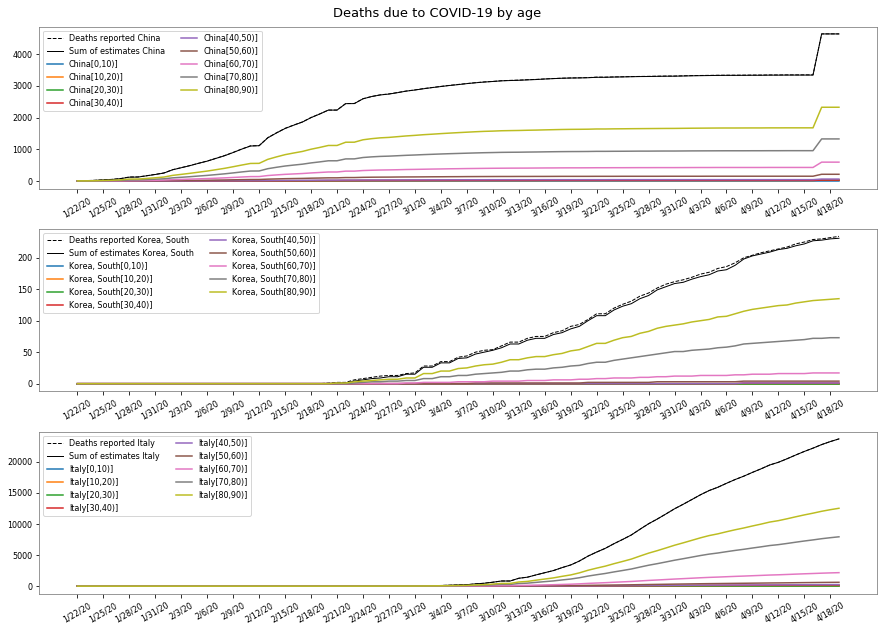

89 days


In [69]:
ages = np.arange(0,90)
f12=gr.figure(figsize=(13,9)); gr.ioff(); rows =3;cols=1
f12.suptitle('Deaths due to COVID-19 by age')
ax=list()
ticks= np.arange(0,nDays,3)
convFactor =1
for n in range(len(ageCountries)):
    ax.append(f12.add_subplot(rows,cols,n+1))
    C = ageCountries[n]
    print(C['Country name'])
    ax[n].plot(C['totDeathCases'],'k--', alpha=1, lw=1,label='Deaths reported '+ C['Country name']);
    ax[n].plot(C['totDeathCases_ageProps'].sum(0),'k',lw=1,label='Sum of estimates '+ C['Country name']);
    for nn in range(len(aGroups)):
        ax[n].plot(C['totDeathCases_ageProps'][nn],label=C['Country name']+ '[%d,%d)]'%(aGroups[nn],aGroups[nn]+10));
    ax[n].legend(loc='upper left',ncol=2, fontsize=8)
    ax[n].set_xticks(ticks)
    ax[n].set_xticklabels(dates[ticks],{'fontsize':8})
    for label in ax[n].get_xticklabels():
        label.set_rotation(30)
        label.set_horizontalalignment('center')
        label.set_fontsize(8)
f12.subplots_adjust(left=0.075,bottom=0.075,right=0.97,top=0.95,wspace=0.2,hspace=0.25)
gr.ion(); gr.draw();  gr.show()

f12Name='figures/tsam_Covid19_JHU_cfr+propDeathCasesByAgeTS.png'
f12.savefig(f12Name)

print('%d days'%nDays)

In [70]:
print(SKorea['totDeathCases_ageProps'].sum(0)[-1])
print(Italy['totDeathCases_ageProps'].sum(0)[-1])
print(China['totDeathCases_ageProps'].sum(0)[-1])

231
23656
4634


### Projections for Mexico

In [71]:
Mexico = dict()
Mexico['cfr'] =cfr[np.where(countries=='Mexico')[0][0]]
Mexico['totCases']=totCases[np.where(countries=='Mexico')[0][0]]
Mexico['totDeathCases']=totDeathCases[np.where(countries=='Mexico')[0][0]]
Mexico['startInd'] = np.where(Mexico['totCases']>0)[0].min()
Mexico['popMillions']= Pops_Millions['Mexico']
Mexico['delayFromReport0']=np.where(Mexico['totCases']>0)[0].min()
print('First case reported %d days after Report 0'%Mexico['delayFromReport0'])

First case reported 37 days after Report 0


In [72]:
def estimateDeathsByAgeMexico(Mexico, dates, subReportFactor=1):
    si = Mexico['delayFromReport0']
    ticks= np.arange(0,len(dates),7)
    casesMexico = subReportFactor * Mexico['totCases']
    f13=gr.figure(figsize=(7,9)); gr.ioff(); rows =3;cols=1;ax=list()
    for n in range(len(ageCountries)):
        ax.append(f13.add_subplot(rows,cols,n+1))
        C = ageCountries[n]
        ax[n].plot(subReportFactor* Mexico['totDeathCases'],'k',lw=1,label='Deaths reported in Mexico');
        ax[n].set_title('Projection based on contributions by age groups from %s using a subreport factor of %d'%(C['Country name'],subReportFactor))
        for nn in range(len(aGroups)):
            ff = casesMexico * Mexico['cfr'] * C['ageDeadCaseProps'][nn]
            ax[n].plot(ff,label='Mexico [%d,%d)]'%(aGroups[nn],aGroups[nn]+10));
            ax[n].legend(loc='upper left',ncol=3, fontsize=8)
        ax[n].set_xticks(ticks)
        ax[n].set_xticklabels(dates[ticks],{'fontsize':8})
        for label in ax[n].get_xticklabels():
            label.set_rotation(0)
            label.set_horizontalalignment('center')
            label.set_fontsize(8)
        ax[n].set_xlim(si,len(Mexico['totDeathCases']))
    f13.subplots_adjust(left=0.075,bottom=0.075,right=0.97,top=0.95,wspace=0.1,hspace=0.25)
    f13Name='figures/tsam_Covid19_JHU_cfr+propDeathCasesByAgeTS_EstimatesMexico_subReportFactor%d.png'%subReportFactor
    gr.ion(); gr.draw();  gr.show()
    f13.savefig(f13Name)
    return f13



### Estimates with a conversion factor of 1

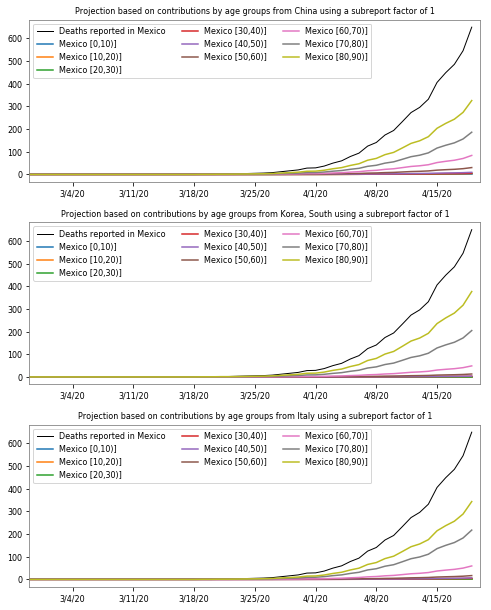

In [73]:
f13_1 = estimateDeathsByAgeMexico(Mexico, dates,subReportFactor=1)


### Estimates with a conversion factor of 10

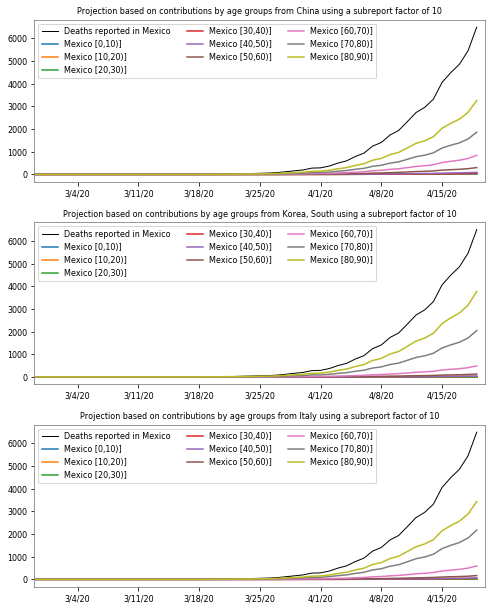

In [74]:
f13_10 = estimateDeathsByAgeMexico(Mexico, dates,subReportFactor=10)


### Estimates with a conversion factor of 12

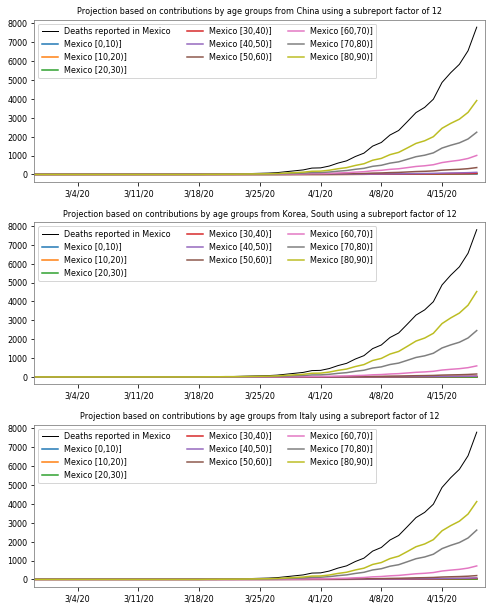

In [75]:
f13_12 = estimateDeathsByAgeMexico(Mexico, dates,subReportFactor=12)
